In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

In [2]:
train_data = pd.read_excel('Data_Train.xlsx')
train_data.dropna(inplace=True)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
train_data['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [4]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)
train_data['Source'] = train_data['Source'].apply(newd)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


In [6]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month

train_data.drop('Date_of_Journey',inplace=True,axis=1)

train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [7]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)

train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [8]:
duration = list(train_data['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

    
train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min
train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


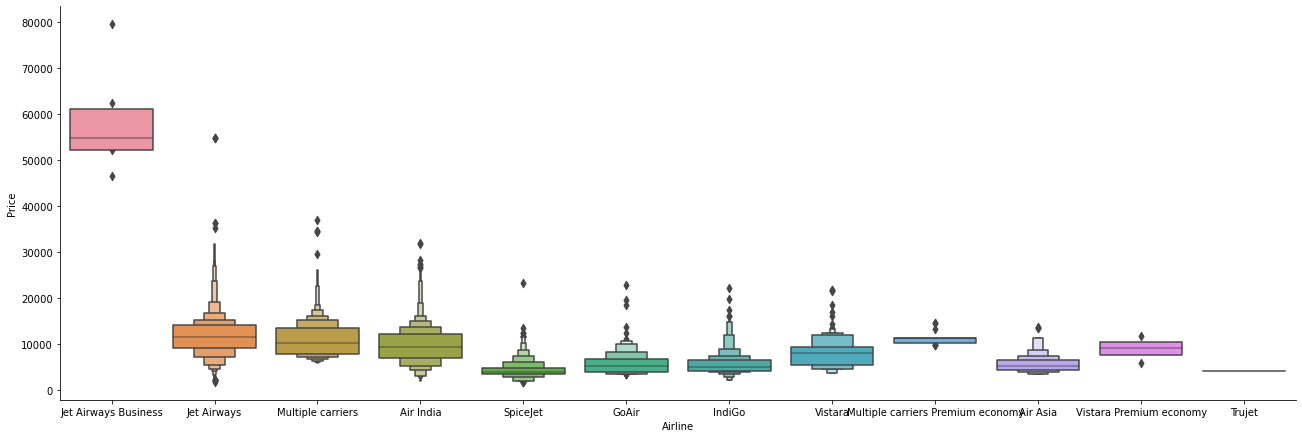

In [9]:
# we can observe that jet airways bussiness is he costliest airways
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

In [10]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline)

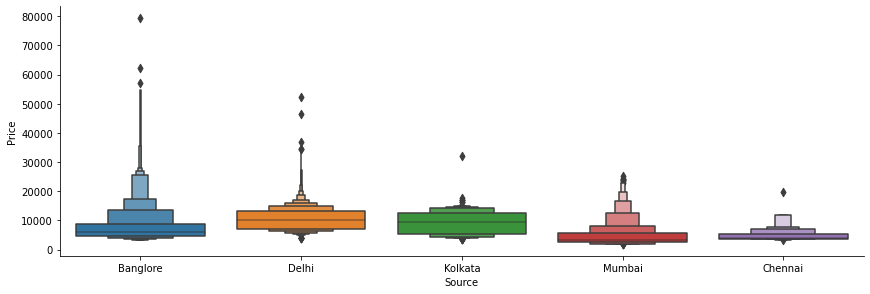

In [11]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [12]:
source = train_data[['Source']]
source = pd.get_dummies(source)
source.head()

,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,0,1,0
4,1,0,0,0,0


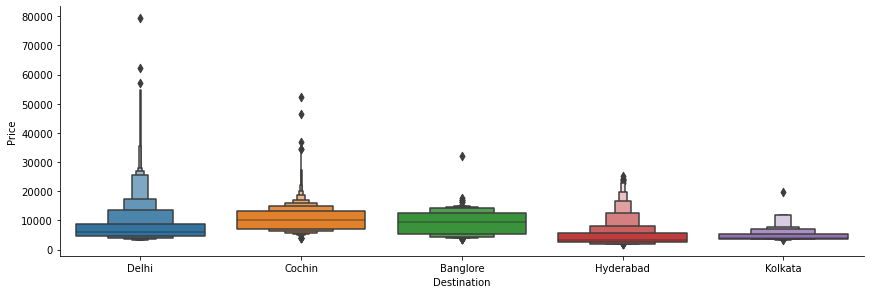

In [13]:
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [14]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination)
destination.head()

,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,0,1,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,1,0,0


In [15]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

In [16]:
train_data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [17]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


In [18]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

(10682, 12)
(10682, 5)
(10682, 5)
(10682, 13)


In [19]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,1,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,1,0,1,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,1,0,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,1,0,1,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,1,0,0,0,0,0,0,1,0,0


# Feature Selection

Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

1. **heatmap** 
2. **feature_importance_** 
3. **SelectKBest**

In [20]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air Asia', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata'],
      dtype='object')

In [21]:
X = data_train.drop(['Price','Dep_hour','Dep_min','Arrival_hour', 'Arrival_min'],axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Duration_hours,Duration_mins,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,...,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,2,50,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,2,1,5,7,25,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,2,9,6,19,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,1,12,5,5,25,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
4,1,1,3,4,45,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0


In [22]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

<AxesSubplot:>

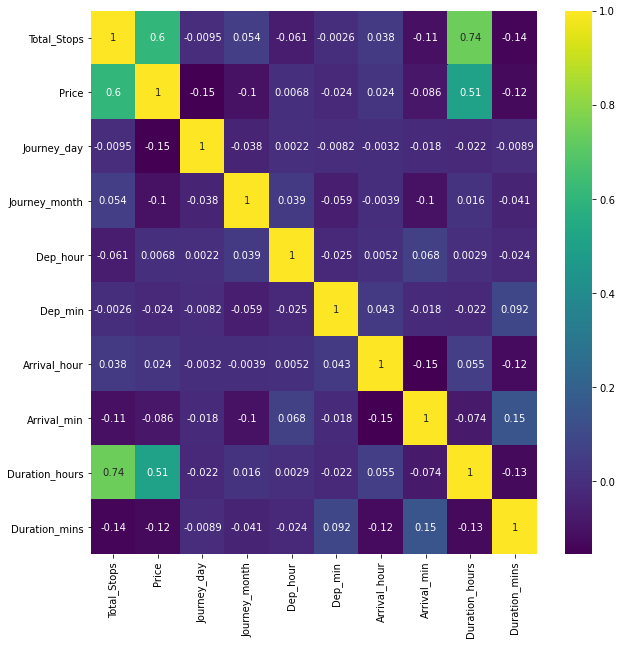

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

In [24]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[2.31320462e-01 1.43983131e-01 6.11597997e-02 1.68424514e-01
 5.65572906e-02 2.84116376e-03 8.50904797e-03 2.21446561e-03
 2.12031282e-02 1.43529999e-01 6.91909224e-02 1.81835064e-02
 8.02616648e-04 5.20055228e-03 1.50538953e-04 4.10427697e-03
 1.39390922e-04 8.73397191e-03 7.62534434e-04 1.04092865e-02
 2.44577949e-03 8.33815408e-03 2.80957664e-03 9.24746858e-03
 1.16693148e-02 7.50397882e-03 5.65129123e-04]


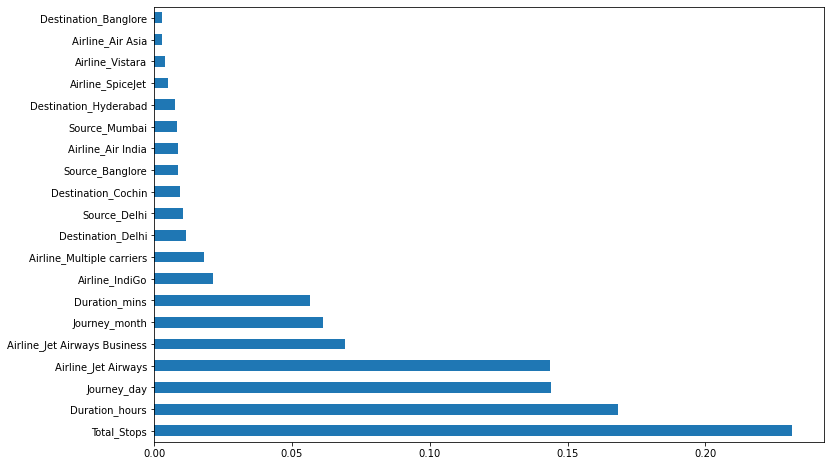

In [25]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Fitting model using Random Forest
1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data(Scaling is not done in Random forest)
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check RSME Score
7. Plot graph

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
etr_random = RandomizedSearchCV(estimator = ExtraTreesRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
etr_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [28]:
etr_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [29]:
prediction = etr_random.predict(X_test)

C:\Users\joane.JOANNAELIZABETH\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


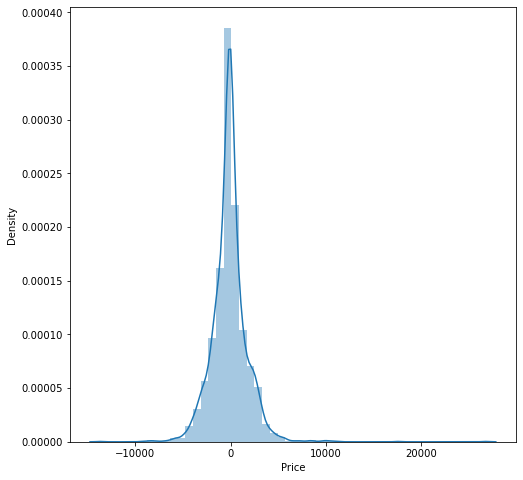

In [30]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

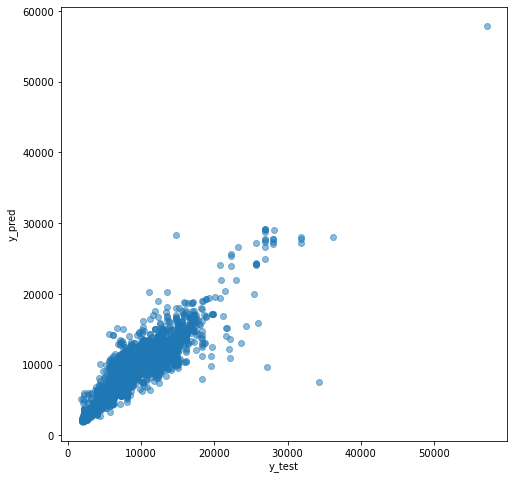

In [31]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [32]:
print('r2 score for ExtraTreesRegressor: ', metrics.r2_score(y_test,prediction))

r2 score for ExtraTreesRegressor:  0.8232324759648901


In [33]:
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [34]:
prediction = rf_random.predict(X_test)

In [35]:
print('r2 score for RandomForestRegressor: ', metrics.r2_score(y_test,prediction))

r2 score for RandomForestRegressor:  0.784563271768218


In [36]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

dt= DecisionTreeRegressor()
knn= KNeighborsRegressor()
lr= LinearRegression()
etr= ExtraTreesRegressor()
rf= RandomForestRegressor()

In [37]:
for i in [dt,knn,lr,etr,rf]:
    i.fit(X_train,y_train)
    pred=i.predict(X_test)
    test_score=r2_score(y_test,pred)
    train_score=r2_score(y_train,i.predict(X_train))
    if abs(train_score-test_score)<=0.1:
        print(i)
    print('R2 score is',r2_score(y_test,pred))
    print('R2 for train data is',r2_score(y_train,i.predict(X_train)))
    print('MSE is',mean_absolute_error(y_test,pred))
    print('*'*30)

R2 score is 0.6323332788843692
R2 for train data is 0.9514276178672638
MSE is 1498.6398019372066
******************************
R2 score is 0.5431810843287659
R2 for train data is 0.6873452200520879
MSE is 2078.840782756665
******************************
LinearRegression()
R2 score is 0.6094137583996728
R2 for train data is 0.6097267701458227
MSE is 1948.3577318044916
******************************
R2 score is 0.6965843504303189
R2 for train data is 0.9514270399704646
MSE is 1434.1329640391434
******************************
R2 score is 0.7308460214033632
R2 for train data is 0.9364011346739236
MSE is 1356.0392509631106
******************************


# Save the model to reuse it again

In [38]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)